In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
import gc
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [171]:
data_reviews= pd.read_csv('C:\\Users\\Tati\\source\\repos\\acamica-datasets\\data_reviews.csv')

In [172]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)
        
data_games = []
for l in parse('C:\\Users\\Tati\\source\\repos\\acamica-datasets\steam_games.json.gz'):
        data_games.append(l)

In [173]:
data_games = pd.DataFrame(data_games)

### DESCRIPCIÓN DE FEATURES DATA_REVIEWS
username: Nombre del usuario que ha dejado la reseña

hours: Cantidad de horas jugadas (acumuladas) en el juego al cual se le ha hecho la reseña

products: Cantidad de otros juegos probados

product_id: Identificacion númerica del juego reseñado

page_order: Número de página en el cual se encuentra el juego dentro de la plataforma

date: Fecha en la cual se ha creado la reseña

text: Comentario sobre el juego

early_access: Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo

page: No es interpretable

user_id: Identificacion númerica del usuario creador de la reseña

found_funny: Cantidad de calificaciones positivas creadas por otros usuarios

compensation: Variable no interpretable dada la cantidad de valores nulos contenidos en ella

In [174]:
data_reviews.head()

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,7.656120e+16


### DESCRIPCIÓN DE FEATURES INCLUIDOS EN DATA_GAMES
desarrollador: Creador del juego

genres: Géneros, caracteristicas del juego

app_name: Editor del juego

title: Nombre del juego

url: Dirección web donde encontrarlo

release_date: Fecha de lanzamiento

tags: Etiquetas relacionadas con el juego

discount_price: Precio con descuento incluido

reviews_url: Dirección web donde encontrar las reseñas sobre el juego

specs: Especificaciones

price: Precio sin descuento

early_access: Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo

id: Identificacion númerica del juego publicado

sentiment: Emoción promedio generada en los usuarios

metascore: Puntaje promedio recibido por los usuarios

In [175]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


### Analisis exploratorio DATA_REVIEWS

Vemos cantidad de filas, columns e informacion sobre cada feature

In [176]:
data_reviews.shape

(7793069, 13)

Data importante para definir los limites del analisis.

In [177]:
data_reviews.loc[:,['hours','products']].describe().round(2)

,hours,products
count,7766532.00,7778108.00
mean,111.84,236.48
std,392.86,485.79
min,0.00,1.00
25%,4.00,45.00
50%,15.30,110.00
75%,59.70,246.00
max,42100.70,18188.00


In [178]:
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7793069 entries, 0 to 7793068
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   username      object 
 2   hours         float64
 3   products      float64
 4   product_id    int64  
 5   page_order    int64  
 6   date          object 
 7   text          object 
 8   early_access  bool   
 9   page          int64  
 10  found_funny   float64
 11  compensation  object 
 12  user_id       float64
dtypes: bool(1), float64(4), int64(4), object(4)
memory usage: 720.9+ MB


Vemos los datos null

In [179]:
data_reviews.isna().sum()

Unnamed: 0            0
username            208
hours             26537
products          14961
product_id            0
page_order            0
date                  0
text              17972
early_access          0
page                  0
found_funny     6592313
compensation    7647446
user_id         4616846
dtype: int64

### De los DATOS analizados hay valores que no vamos a considerar, tales como:

* Usuarios con menos de 15 horas jugadas (falta de expertise)

* Usuarios con menos 30 juegos (falta de expertise)

* Usuarios que jugaron mas de 100 horas a un juego (exceso, claramente el juego le gusta)

* Usuarios que jugaron mas de 300 juegos. (es demasiado y se sale del perfil que queremos considerar)

In [213]:
data_reviews2=data_reviews[(data_reviews.products>15) & (data_reviews.products<30)]
data_reviews3=data_reviews2[(data_reviews2.hours>10) & (data_reviews2.hours<100)]
data_reviews3.dropna(subset=['text'], inplace=True)

<ipython-input-213-874d012de9b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reviews3.dropna(subset=['text'], inplace=True)


In [214]:
data_reviews3.head(10)

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
39,39,xiodeni,18.4,18.0,35140,6,2018-01-03,I definitely recommend this game. I absolutely...,False,1,NaN,NaN,NaN
130,130,Sir Dan the Super Chivalrous,27.0,16.0,506510,5,2017-12-19,is more than a love letter to SNES era RPGS. T...,False,1,NaN,NaN,NaN
195,195,Keymasher,22.8,18.0,35140,8,2018-01-01,I always loved the Batman: Arkham games so I w...,False,2,NaN,NaN,7.656120e+16
217,217,dogminster,24.6,20.0,506510,0,2017-11-23,Just finished playing through and had blast. O...,False,2,NaN,NaN,7.656120e+16
334,334,baconn07,18.1,29.0,35140,2,2017-12-31,Its great even though its 8 years,False,3,NaN,NaN,7.656120e+16
422,422,Joorie,11.2,25.0,452570,6,2017-12-30,If your looking for something to play out of b...,False,1,NaN,NaN,NaN
567,567,WojoBread,22.4,27.0,1840,5,2018-01-01,I can make better sandwiches than this program,False,4,NaN,NaN,NaN
568,568,MashedPotatoeSause,12.1,21.0,1840,6,2018-01-01,I'm just puting in a negative review to add va...,False,4,8.0,NaN,7.656120e+16
592,592,Kachigga,69.9,23.0,1840,9,2018-01-01,Quite difficult to learn to use but after a co...,False,4,NaN,NaN,7.656120e+16
723,723,Riganone,12.6,19.0,745880,9,2017-12-18,This is a good way to test if your fingers and...,False,4,6.0,NaN,NaN


Elimino aquellas instancias que no tengan usuario

In [215]:
empty_indexs=data_reviews3[data_reviews3.username.isna()].index
empty_indexs

Int64Index([3775656, 4514493, 4873973, 6007473, 6264615], dtype='int64')

In [216]:
data_reviews3.drop(empty_indexs,inplace=True)

C:\Users\Tati\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [217]:
data_reviews3.hours.isna().sum()

0

Filtro aquellas columnas que no considero utiles para le analisis

In [218]:
data_reviews4=data_reviews3.loc[:,['username','hours','products','product_id','text']]
data_reviews4.isna().sum()
del data_reviews3
data_reviews4

,username,hours,products,product_id,text
39,xiodeni,18.4,18.0,35140,I definitely recommend this game. I absolutely...
130,Sir Dan the Super Chivalrous,27.0,16.0,506510,is more than a love letter to SNES era RPGS. T...
195,Keymasher,22.8,18.0,35140,I always loved the Batman: Arkham games so I w...
217,dogminster,24.6,20.0,506510,Just finished playing through and had blast. O...
334,baconn07,18.1,29.0,35140,Its great even though its 8 years
...,...,...,...,...,...
7792455,Omega-Shenron,56.8,29.0,252490,Lots of fun hopefully will get better and better
7792473,Pobot,48.9,21.0,252490,this game is soo good.
7792527,Sloba™,47.0,25.0,252490,"This game is so much fun,that anyone who plays..."
7792665,Testikills,79.4,19.0,252490,Joke of a dev team. Usually I try not to buy e...


Realizamos algunos graficos para ver la distribucion de algunas variables

<AxesSubplot:xlabel='products'>

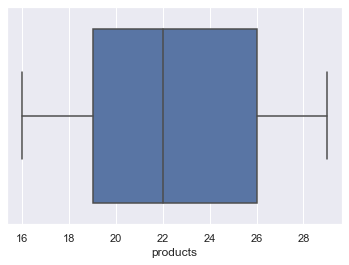

In [219]:
sns.boxplot(x = data_reviews4.products)

<AxesSubplot:xlabel='hours'>

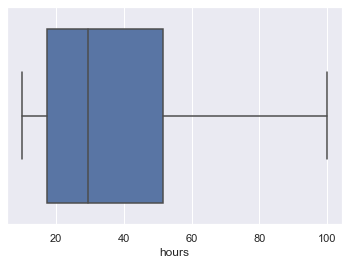

In [220]:
sns.boxplot(x = data_reviews4.hours)

<AxesSubplot:xlabel='products', ylabel='Density'>

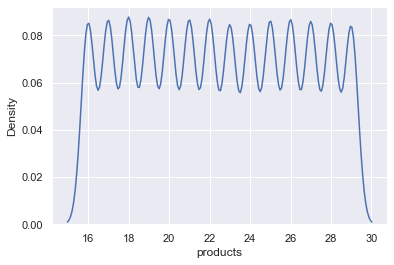

In [221]:
sns.kdeplot(data=data_reviews4.products)

<AxesSubplot:xlabel='hours', ylabel='Density'>

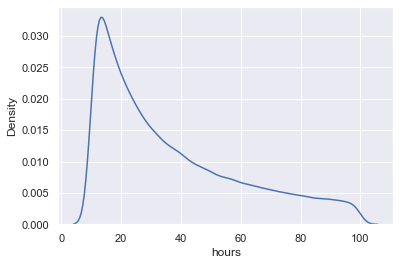

In [222]:
sns.kdeplot(data=data_reviews4.hours)

#### Para completar el analisis exploratorio de data_reviews:

In [223]:
data_reviews4.head(9090).username.value_counts().mean()

1.1446921042689837

1. Que cantidad de reviews deja en promedio cada usuario?

In [224]:
reviews_prom=data_reviews4.username.value_counts().mean()
print(f'El promedio de reviews por usuario es:{reviews_prom}')

El promedio de reviews por usuario es:1.5143909842376884


2. Dentro de los limites establecidos, cuales son los usuarios que mas reviews dejaron?


In [225]:
data_reviews4['username'].value_counts()[0:15].index.tolist()

['123',
 'Alex',
 '-13-',
 'Matt',
 'Ghost',
 'Red',
 'Jeff',
 'Shadow',
 'Wolf',
 '..',
 'Alpha',
 '...',
 'Blaze',
 'Dan',
 'Fox']

3. Dentro de los limites establecidos, cuales son los usuarios que menos reviews dejaron?

In [226]:
data_reviews4['username'].value_counts()[-15:-1].index.tolist()

['AeroVictor',
 'Meister666',
 'ツ MaruChan ツ',
 'OutlinedHalo033',
 'Relatively large Max',
 'Martron',
 'A killing chicken',
 '[|[308th]|] Darth Techron',
 'borange01',
 'Dracoking',
 'The Meh man',
 'Roply',
 'Jokes_On_You',
 'Chuckybgood']

4. Cual es el juego que mas reviews tuvo? cual el que menos reviews tuvo?

In [227]:
data_reviews4.product_id.mode()

0    440
dtype: int64

In [228]:
data_reviews4.username.value_counts().describe()

count    157147.000000
mean          1.514391
std           1.222267
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          64.000000
Name: username, dtype: float64

(0.0, 10.0)

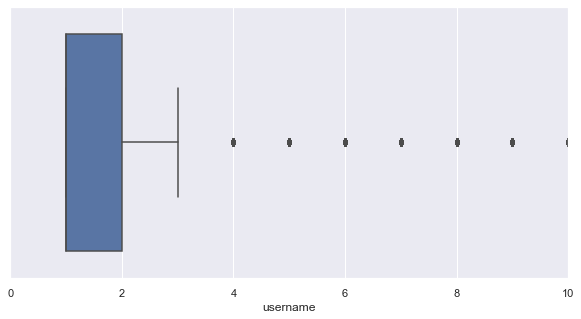

In [229]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x=data_reviews4.username.value_counts())
ax.set_xlim([0,10])

A continuación determino por medio de TextBlob, la polaridad de un review analizando la variable Text.
La Polaridad es un número décimal que oscila entre -1 y 1, donde 1 significa que el comentario transmite un sentimiento positivo y, -1 un sentimiento negativo

In [230]:
len(data_reviews4.text)

237982

In [231]:
polarity_list=[]
exceptions=[]
for i in range(len(data_reviews4.text)):
    #print(data_reviews4.text.iloc[i])
    if(isinstance(data_reviews4.text.iloc[i], float)):
        exceptions.append(data_reviews4.text.iloc[i])
    else:
        frase=TextBlob(data_reviews4.text.iloc[i])
        polarity=frase.sentiment.polarity
        polarity_list.append(polarity)

In [238]:
len(exceptions)

0

In [239]:
data_reviews4['Polarity']=pd.Series(polarity_list)

### Analisis exploratorio Data Games

In [240]:
data_games['title'].unique().shape

(30054,)

In [241]:
data_games[data_games.id=="35140"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [242]:
data_games.drop_duplicates(subset ="id",
                     keep = False, inplace = True)

In [243]:
data_games[data_games.id=="35140"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [244]:
data_games.shape

(32131, 16)

In [245]:
data_games.id.unique().size

32131

In [246]:
url_splited = data_games.url.str.split('/')
url_splited

0        [http:, , store.steampowered.com, app, 761140,...
1        [http:, , store.steampowered.com, app, 643980,...
2        [http:, , store.steampowered.com, app, 670290,...
3        [http:, , store.steampowered.com, app, 767400,...
4        [http:, , store.steampowered.com, app, 773570,...
                               ...                        
32130    [http:, , store.steampowered.com, app, 773640,...
32131    [http:, , store.steampowered.com, app, 733530,...
32132    [http:, , store.steampowered.com, app, 610660,...
32133    [http:, , store.steampowered.com, app, 658870,...
32134    [http:, , store.steampowered.com, app, 681550,...
Name: url, Length: 32131, dtype: object

In [247]:
resultados = []
data_games["URL_NAME"] = ""
k=0
m = 5
for i in url_splited:
    data_games["URL_NAME"].iloc[k] = i[m]
    resultados.append(i[5])
    k=k+1
k=0

C:\Users\Tati\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [248]:
resultados

['Lost_Summoner_Kitty',
 'Ironbound',
 'Real_Pool_3D__Poolians',
 '2222',
 'Log_Challenge',
 'Battle_Royale_Trainer',
 'SNOW__All_Access_Basic_Pass',
 'SNOW__All_Access_Pro_Pass',
 'SNOW__All_Access_Legend_Pass',
 'Race',
 'Uncanny_Islands',
 'Icarus_Six_Sixty_Six',
 'Army_of_Tentacles_Not_A_Cthulhu_Dating_Sim_Black_GOAT_of_the_Woods_Edition',
 'Beach_Rules',
 'Planetarium_2__Zen_Odyssey',
 'The_first_thrust_of_God',
 'SNOW__Starter_Pack',
 'The_first_thrust_of_God__All_Aircrafts',
 'SNOW__Lifetime_Pack',
 'After_Life_VR',
 'Kitty_Hawk',
 'The_Warrior_Of_Treasures',
 'Mortars_VR',
 'RC_Plane_3__Canyon_Scenario',
 'RC_Plane_3__F53B',
 'DinoBlaster',
 'Robotpencil_Presents_Understanding_3D_for_Concept',
 'Carmageddon_Max_Pack',
 'HalfLife',
 'Fallen_Mage',
 'Dont_Get_Hit_In_The_Face',
 'Lost_Cities',
 'Twisted_Enhanced_Edition',
 'Vaporwave_Simulator',
 'Tactics_Forever',
 'Christmas_Santa_Troubles',
 'Kingdom_Watcher',
 'Underdone__Soundtrack',
 'Bitcoin_Clicker',
 'Disciples_II_Gallean

In [249]:
##data_games.drop(['title'],inplace=True,axis=1)

In [250]:
data_games[data_games.id=="35140"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,URL_NAME
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91,Batman_Arkham_Asylum_Game_of_the_Year_Edition


In [251]:
data_games.early_access.value_counts()
print( f'El {1947/(30184+1947)*100}% son juegos que permiten ser probados antes de su lanzamiento ')

El 6.059568640876412% son juegos que permiten ser probados antes de su lanzamiento 


In [252]:
data_games['price'].fillna('null',inplace=True)

In [253]:
data_games['price_']=data_games['price']

In [254]:
data_games['price_']

0                4.99
1        Free To Play
2        Free to Play
3                0.99
4                2.99
             ...     
32130            1.99
32131            4.99
32132            1.99
32133            4.99
32134            4.99
Name: price_, Length: 32131, dtype: object

In [255]:
k=0
for y in data_games.price_:
    if(isinstance(y, str)):
        if (y.find('Starting')!=-1):
            data_games.price_[k]=y.split(' ')[-1]
            data_games.price_[k]= float(data_games.price_[k].replace("$", ""))
        else:
            data_games.price_[k]=0.00
    k=k+1

<ipython-input-255-3c5953ea5c20>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_games.price_[k]=0.00
<ipython-input-255-3c5953ea5c20>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_games.price_[k]=y.split(' ')[-1]
<ipython-input-255-3c5953ea5c20>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_games.price_[k]= float(data_games.price_[k].replace("$", ""))


In [256]:
data_games.price_.unique()

array([4.99, 0.0, 0.99, 2.99, 3.99, 9.99, 18.99, 29.99, 10.99, 1.59,
       14.99, 1.99, 59.99, 8.99, 6.99, 7.99, 39.99, 19.99, 7.49, 'null',
       12.99, 5.99, 2.49, 'Free', 1.25, 'Free to Play', 24.99, 17.99,
       61.99, 3.49, 11.99, 13.99, 'Free Demo', 'Play for Free!', 74.76,
       1.49, 32.99, 99.99, 14.95, 69.99, 16.99, 79.99, 49.99, 5.0, 44.99,
       13.98, 'Free To Play', 15.99, 34.99, 29.96, 119.99, 109.99, 149.99,
       'Install Now', 21.99, 89.99, 'Play WARMACHINE: Tactics Demo',
       139.92, 4.29, 64.99, 'Free Mod', 54.99, 74.99, 'Install Theme',
       0.89, 'Third-party', 0.5, 'Play Now', 1.29, 3.0, 15.0, 5.49, 23.99,
       49.0, 20.99, 10.93, 1.39, 'Free HITMAN™ Holiday Pack', 36.99, 4.49,
       2.0, 4.0, 234.99, 1.95, 1.5, 199.0, 189.0, 6.66, 27.99, 10.49,
       129.99, 179.0, 26.99, 399.99, 31.99, 399.0, 20.0, 40.0, 3.33,
       199.99, 22.99, 320.0, 38.85, 71.7, 59.95, 995.0, 3.39, 19.95,
       499.99, 16.06, 4.68, 131.4, 202.76, 1.0, 2.3, 0.95, 172.24, 29

In [257]:
data_games2=data_games.loc[:,['URL_NAME','id']]

In [258]:
type(data_games.price_.iloc[14])

float

In [259]:
#plt.figure(figsize=(20, 10))
#sns.boxplot(x=data_games.precie_[data_games.precie_<399])

In [260]:
data_games2.id=pd.to_numeric(data_games2.id,downcast='integer')

In [261]:
data_games2[data_games2.id==35140]

,URL_NAME,id
31617,Batman_Arkham_Asylum_Game_of_the_Year_Edition,35140


In [262]:
data_reviews4

,username,hours,products,product_id,text,Polarity
39,xiodeni,18.4,18.0,35140,I definitely recommend this game. I absolutely...,0.179866
130,Sir Dan the Super Chivalrous,27.0,16.0,506510,is more than a love letter to SNES era RPGS. T...,0.180000
195,Keymasher,22.8,18.0,35140,I always loved the Batman: Arkham games so I w...,0.700000
217,dogminster,24.6,20.0,506510,Just finished playing through and had blast. O...,-0.050000
334,baconn07,18.1,29.0,35140,Its great even though its 8 years,0.415000
...,...,...,...,...,...,...
7792455,Omega-Shenron,56.8,29.0,252490,Lots of fun hopefully will get better and better,NaN
7792473,Pobot,48.9,21.0,252490,this game is soo good.,NaN
7792527,Sloba™,47.0,25.0,252490,"This game is so much fun,that anyone who plays...",NaN
7792665,Testikills,79.4,19.0,252490,Joke of a dev team. Usually I try not to buy e...,NaN


In [263]:
data_to_export = pd.merge(data_reviews4, data_games2, left_on='product_id', right_on='id', how='left').drop('id', axis=1)

In [264]:
#data_to_export.drop(['text'],inplace=True,axis=1)
#data_to_export

In [266]:
data_to_export.to_csv('C:\\Users\\Tati\\source\\repos\\data_full.csv')